Checking the class imbalance in the labels

In [1]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)
# !pip install tqdm
import tqdm

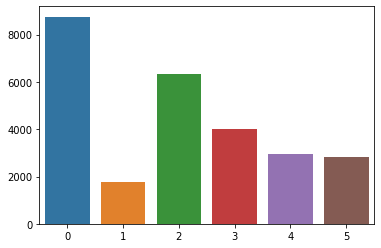

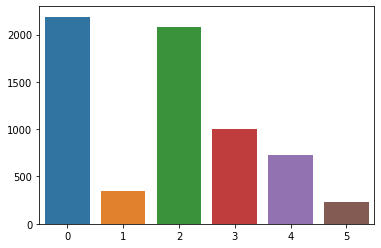

In [2]:

f = open('../input/tig-aluminium-5083/al5083/train/train.json')
data_json = json.load(f)
data_df = pd.DataFrame.from_dict(data_json, orient='index').reset_index()
data_df.columns = ['path','label']
sns.barplot(x = list(data_df['label'].value_counts().index), y =data_df['label'].value_counts().values)
plt.show()

f = open('../input/tig-aluminium-5083/al5083/test/test.json')
data_json = json.load(f)
data_df = pd.DataFrame.from_dict(data_json, orient='index').reset_index()
data_df.columns = ['path','label']
sns.barplot(x = list(data_df['label'].value_counts().index),y = data_df['label'].value_counts().values)
plt.show()

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size_train = 96
batch_size_test = 96
valid_size = 0.2

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

class TIGDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        f = open(json_file)
        self.json_data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {0:'good weld',1:'burn through',2:'contamination',3:'lack of fusion',4:'misalignment',5:'lack of penetration'}

    def __len__(self):
        return len(self.json_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, list(self.json_data.keys())[index])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.json_data[list(self.json_data.keys())[index]]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
train_dataset = TIGDataset(
    json_file='../input/tig-aluminium-5083/al5083/train/train.json',
    root_dir='../input/tig-aluminium-5083/al5083/train',
    transform=transform_train,
)

test_dataset = TIGDataset(
    json_file='../input/tig-aluminium-5083/al5083/test/test.json',
    root_dir="../input/tig-aluminium-5083/al5083/test",
    transform=transform_test,
)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_test, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, 
    num_workers=num_workers)



loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [4]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

223
56
69


tensor([2, 2, 0, 3, 2, 0, 2, 0, 5, 0, 2, 2, 0, 0, 0, 0, 0, 5, 5, 0, 1, 0, 3, 4,
        0, 2, 0, 0, 3, 3, 0, 2, 2, 0, 5, 0, 1, 4, 2, 0, 2, 5, 0, 0, 0, 2, 3, 4,
        3, 1, 3, 0, 3, 5, 0, 2, 1, 2, 1, 0, 2, 2, 2, 0, 0, 0, 4, 0, 2, 2, 0, 3,
        2, 3, 5, 4, 1, 0, 2, 2, 5, 2, 4, 0, 0, 0, 3, 4, 0, 2, 4, 4, 0, 5, 5, 0])

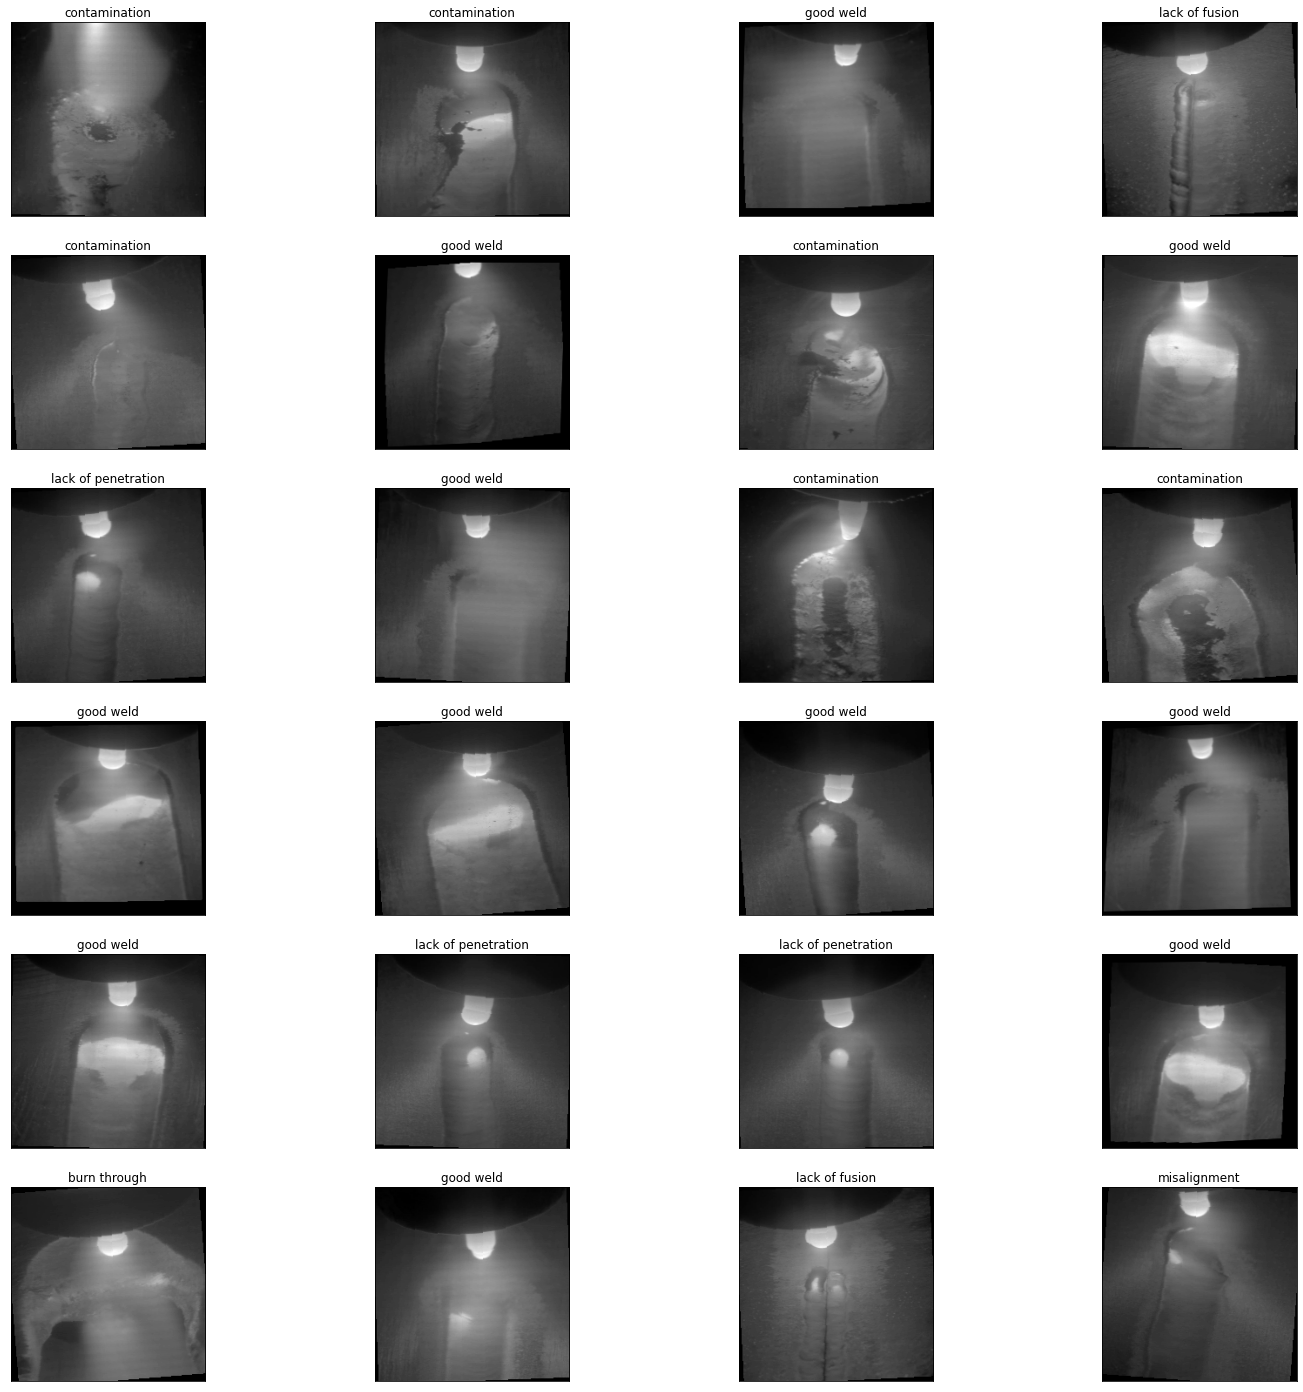

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray') 
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = train_dataset.class_to_idx

# print(labels)
# train_data.classes
fig = plt.figure(figsize=(25, 25))
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
for idx in np.arange(24):
    ax = fig.add_subplot(6,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels.numpy()[idx]])
labels

In [6]:
criterion_transfer = nn.CrossEntropyLoss()

# def get_optimizer_transfer(model):
#     ## TODO: select and return an optimizer
#     optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#     return optimizer 

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.014)
    return optimizer 

In [7]:
from torchvision import datasets, models, transforms
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
    
use_cuda = torch.cuda.is_available()

n_classes = 6
n_inputs = vgg16.classifier[6].in_features
# n_inputs will be 4096 for this case

# vgg16.classifier[6] = nn.Sequential(
#     nn.Linear(n_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, n_classes)
# #     ,nn.Softmax(dim=1)
# )

vgg16.classifier[6] = nn.Linear(n_inputs, n_classes)

model_transfer = vgg16

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
!pip install torchsummary
from torchsummary import summary
summary(model_transfer, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = {}
    valid_losses = {}
    
    for epoch in range(1, n_epochs+1):
        train_loss_list = []
        valid_loss_list = []
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f'Epoch: {epoch}')
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        print('Training set:')
        for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['train'])):
#             print(batch_idx)
            # move to GPU
            data = data.expand(data.size()[0], 3, *data.size()[2:])
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            train_loss_list.append(loss.data.item())
   

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        print('Validation set:')
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['valid'])):
                # move to GPU
                data = data.expand(data.size()[0], 3, *data.size()[2:])
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## TODO: update average validation loss 

                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
                
                valid_loss_list.append(loss.data.item())

            
        # print training/validation statistics 
        train_losses[epoch] = train_loss_list
        valid_losses[epoch] = valid_loss_list
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    return model, train_losses, valid_losses

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    losses = []
    pred_label = []
    true_label = []
    correct = 0.
    total = 0.
    print('Test set')
    # set the module to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['test'])):
            # move to GPU
            data = data.expand(data.size()[0], 3, *data.size()[2:])
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            losses.append(loss.data.item())
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
            # convert output probabilities to predicted class
#             _,pred = output.data.max(1, keepdim=True)[1]
            _,pred = torch.max(output, 1) ## fetching the indices of max values
            
            pred_label.extend(pred.cpu().numpy().reshape(-1,))
            true_label.extend(target.cpu().numpy().reshape(-1,))
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return losses, true_label, pred_label

In [11]:
n_epochs = 20
_, train_losses, valid_losses = train(n_epochs, loaders, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer6.pt')

model_transfer.load_state_dict(torch.load('model_transfer6.pt'))

losses, true_label, pred_label  = test(loaders, model_transfer, criterion_transfer, use_cuda)

%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'model_transfer6.pt')

Epoch: 1
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.545998 	Validation Loss: 0.319567
Validation loss decreased (inf --> 0.319567).  Saving model ...
Epoch: 2
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.254058 	Validation Loss: 0.162374
Validation loss decreased (0.319567 --> 0.162374).  Saving model ...
Epoch: 3
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.184468 	Validation Loss: 0.143041
Validation loss decreased (0.162374 --> 0.143041).  Saving model ...
Epoch: 4
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.149967 	Validation Loss: 0.129151
Validation loss decreased (0.143041 --> 0.129151).  Saving model ...
Epoch: 5
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.122160 	Validation Loss: 0.135711
Epoch: 6
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.103325 	Validation Loss: 0.094471
Validation loss decreased (0.129151 --> 0.094471).  Saving model ...
Epoch: 7
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.088917 	Validation Loss: 0.061368
Validation loss decreased (0.094471 --> 0.061368).  Saving model ...
Epoch: 8
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.079578 	Validation Loss: 0.073155
Epoch: 9
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.071175 	Validation Loss: 0.070791
Epoch: 10
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.065910 	Validation Loss: 0.054843
Validation loss decreased (0.061368 --> 0.054843).  Saving model ...
Epoch: 11
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.059737 	Validation Loss: 0.083558
Epoch: 12
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.054835 	Validation Loss: 0.096410
Epoch: 13
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.053050 	Validation Loss: 0.037434
Validation loss decreased (0.054843 --> 0.037434).  Saving model ...
Epoch: 14
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.048539 	Validation Loss: 0.039060
Epoch: 15
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.047136 	Validation Loss: 0.033429
Validation loss decreased (0.037434 --> 0.033429).  Saving model ...
Epoch: 16
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.041522 	Validation Loss: 0.032401
Validation loss decreased (0.033429 --> 0.032401).  Saving model ...
Epoch: 17
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.038910 	Validation Loss: 0.030526
Validation loss decreased (0.032401 --> 0.030526).  Saving model ...
Epoch: 18
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.037318 	Validation Loss: 0.026524
Validation loss decreased (0.030526 --> 0.026524).  Saving model ...
Epoch: 19
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.035486 	Validation Loss: 0.055488
Epoch: 20
Training set:


  0%|          | 0/223 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.035633 	Validation Loss: 0.024927
Validation loss decreased (0.026524 --> 0.024927).  Saving model ...
Test set


  0%|          | 0/69 [00:00<?, ?it/s]

Test Loss: 1.137383


Test Accuracy: 81% (5339/6588)
/kaggle/working


/kaggle/working/model_transfer6.pt

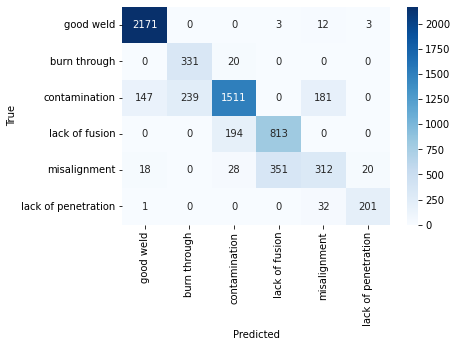

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2189
           1       0.58      0.94      0.72       351
           2       0.86      0.73      0.79      2078
           3       0.70      0.81      0.75      1007
           4       0.58      0.43      0.49       729
           5       0.90      0.86      0.88       234

    accuracy                           0.81      6588
   macro avg       0.76      0.79      0.76      6588
weighted avg       0.81      0.81      0.81      6588



In [12]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(true_label, pred_label)
ax = sns.heatmap(c_matrix, annot=True,fmt='', cmap='Blues', 
                 xticklabels = test_dataset.class_to_idx.values(), yticklabels = test_dataset.class_to_idx.values())
ax.set(xlabel='Predicted', ylabel='True')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(true_label, pred_label))

In [13]:
# model_transfer.eval()
# with torch.no_grad():
#     ll = enumerate(loaders['test'])
#     for i in range(11):
#         next(ll)
#     for batch_idx, (data, target) in ll:
#         # move to GPU
#         data = data.expand(data.size()[0], 3, *data.size()[2:])
#         if use_cuda:
#             data, target = data.cuda(), target.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model_transfer(data)
#         # calculate the loss
#         loss = criterion_transfer(output, target)
#         losses.append(loss.data.item())
#         # update average test loss 
#         test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
#         # convert output probabilities to predicted class
#         _,pred = torch.max(output, 1)
#         break
